# PART 1

Görüntü dizin yolları ve gerekli kütüphaneler tanımlandı.  

The image directory paths and required libraries are defined.

In [ ]:
import tensorflow as tf
from pathlib import Path
from PIL import Image

base_dir  = Path.home() / "Desktop" / "data.set" / "indoorCVPR_09" / "Images"
train_txt = Path.home() / "Desktop" / "data.set" / "TrainImages.txt"
test_txt  = Path.home() / "Desktop" / "data.set" / "TestImages.txt"


Train ve test veri dosyaları okunarak, her bir görüntünün tam dosya yolları oluşturuldu.  

The train and test text files are read, and full file paths for each image are created.

In [ ]:
with open(train_txt, "r") as f:
    train_paths = [base_dir / line.strip() for line in f]

with open(test_txt, "r") as f:
    test_paths  = [base_dir / line.strip() for line in f]

print(f"Toplam Train görüntü: {len(train_paths)}, Test görüntü: {len(test_paths)}")


Toplam Train görüntü: 5360, Test görüntü: 1340


Görüntülerin klasör adları etiket (label) olarak çıkarıldı.  

The folder names of the images are extracted as labels.


In [ ]:
train_labels = [p.parent.name for p in train_paths]
test_labels  = [p.parent.name for p in test_paths]

Etiketler sayısal indekslere dönüştürülerek sınıflandırma için hazırlandı.  

The labels are converted to numerical indices to prepare for classification.

In [ ]:
class_names    = sorted(set(train_labels))
label_to_index = {name: idx for idx, name in enumerate(class_names)}

train_indices = [label_to_index[l] for l in train_labels]
test_indices  = [label_to_index[l] for l in test_labels]

print("Sınıf sayısı:", len(class_names))


Sınıf sayısı: 67


Path nesneleri string (metin) tipine dönüştürüldü. 

Path objects are converted to string format.

In [ ]:
train_path_strs = [str(p) for p in train_paths]
test_path_strs  = [str(p) for p in test_paths]

PIL kullanılarak tüm görüntüler yüklendi, bozuk veya açılamayan dosyalar listeden çıkarıldı. 
 
All images are loaded using PIL, and corrupted or unreadable files are removed from the list.

In [ ]:
def deep_filter(path_strs, labels):
    valid_p, valid_l = [], []
    for p, l in zip(path_strs, labels):
        try:
            with Image.open(p) as img:
                img.load()
            valid_p.append(p)
            valid_l.append(l)
        except Exception:
            # bozuk dosya, atla
            pass
    return valid_p, valid_l

train_path_strs, train_indices = deep_filter(train_path_strs, train_indices)
test_path_strs,  test_indices  = deep_filter(test_path_strs,  test_indices)

print(f"Filtre sonrası: Train={len(train_path_strs)}, Test={len(test_path_strs)}")


Filtre sonrası: Train=5360, Test=1340


Görüntü boyutu ve batch size belirlendi, ayrıca veriyi okuyup yeniden boyutlandıran ön işleme fonksiyonu tanımlandı.  

Image size and batch size are defined, and a preprocessing function is created to read and resize the images.

In [ ]:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label


Veri setleri tf.data pipeline ile oluşturuldu, hatalı örnekler otomatik olarak atlandı.  

The datasets are created using tf.data pipeline, and faulty samples are automatically skipped.


In [ ]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_path_strs, train_indices))
      .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
      .shuffle(1000)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
      .ignore_errors()     # Hatalı örnekleri atla
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_path_strs, test_indices))
      .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
      .ignore_errors()    # Hatalı örnekleri atla
)


Eğitim verisinin %20'si doğrulama (validation) seti olarak ayrıldı, val_ds oluşturuldu.  

20% of the training data is separated as a validation set, and val_ds is created.


In [ ]:
from sklearn.model_selection import train_test_split

train_paths_split, val_paths_split, train_idx_split, val_idx_split = train_test_split(
    train_path_strs,
    train_indices,
    test_size=0.2,
    stratify=train_indices,
    random_state=42
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_paths_split, val_idx_split))
      .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)


Temel bir CNN modeli tanımlandı ve derlendi. Model, sınıflandırma için softmax katmanı içerir.  

A basic CNN model is defined and compiled. The model includes a softmax layer for classification.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(*IMG_SIZE,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


C:\Users\Can\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 67)             │         8,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,916,035 (91.23 MB)

 Trainable params: 23,916,035 (91.23 MB)

 Non-trainable params: 0 (0.00 B)

Model eğitim süreci başlatıldı, erken durdurma (early stopping) ile aşırı öğrenme önleniyor.  

The model training is initiated with early stopping to prevent overfitting.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=19,
    callbacks=[es]
)

Epoch 1/19
    168/Unknown 32s 186ms/step - accuracy: 0.0166 - loss: 5.5172

C:\Users\Can\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


168/168 ━━━━━━━━━━━━━━━━━━━━ 34s 197ms/step - accuracy: 0.0166 - loss: 5.5112 - val_accuracy: 0.0373 - val_loss: 4.1356
Epoch 2/19
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 193ms/step - accuracy: 0.0334 - loss: 4.1470 - val_accuracy: 0.1595 - val_loss: 3.9085
Epoch 3/19
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 192ms/step - accuracy: 0.0734 - loss: 3.9216 - val_accuracy: 0.4272 - val_loss: 3.0766
Epoch 4/19
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 194ms/step - accuracy: 0.1948 - loss: 3.2665 - val_accuracy: 0.7789 - val_loss: 1.8222
Epoch 5/19
168/168 ━━━━━━━━━━━━━━━━━━━━ 37s 217ms/step - accuracy: 0.4058 - loss: 2.3488 - val_accuracy: 0.9123 - val_loss: 0.9143
Epoch 6/19
168/168 ━━━━━━━━━━━━━━━━━━━━ 37s 220ms/step - accuracy: 0.5712 - loss: 1.5963 - val_accuracy: 0.9767 - val_loss: 0.3662
Epoch 7/19
168/168 ━━━━━━━━━━━━━━━━━━━━ 38s 224ms/step - accuracy: 0.6604 - loss: 1.2298 - val_accuracy: 0.9860 - val_loss: 0.1859
Epoch 8/19
168/168 ━━━━━━━━━━━━━━━━━━━━ 39s 230ms/step - accuracy: 0.7503 - loss: 0.8918 - val

Eğitim ve doğrulama kayıp/doğruluk grafiklerinin görselleştirilmesi yapıldı.  

Training and validation loss/accuracy graphs are visualized.


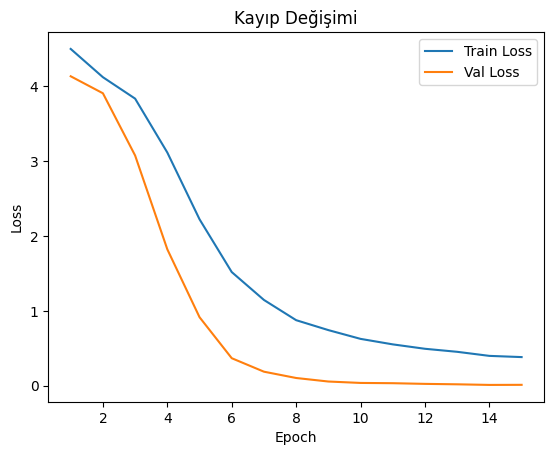

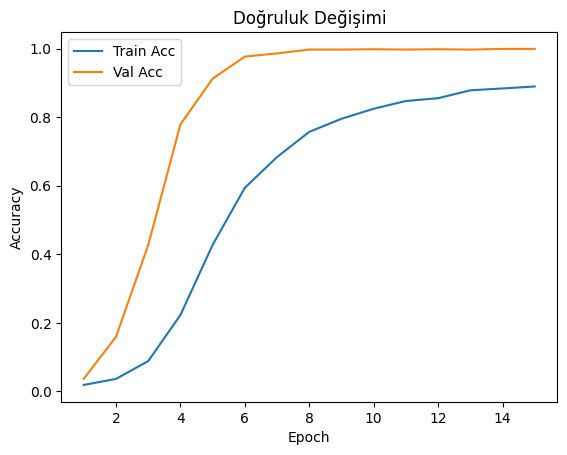

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'],    label='Train Loss')
plt.plot(epochs, history.history['val_loss'],label='Val Loss')
plt.title('Kayıp Değişimi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history.history['accuracy'],    label='Train Acc')
plt.plot(epochs, history.history['val_accuracy'],label='Val Acc')
plt.title('Doğruluk Değişimi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Farklı öğrenme oranı ve batch size kombinasyonları için grid search yapılarak model denemeleri gerçekleştirildi.  

A grid search is performed with different learning rate and batch size combinations to test multiple models.


In [ ]:
# Orijinal dataset
orig_train = train_ds.unbatch()
orig_val   = val_ds.unbatch()

input_shape = (*IMG_SIZE, 3)    # IMG_SIZE = (224,224)
num_classes = len(class_names)

histories = {}

for lr in [1e-2, 1e-3, 1e-4]:
    for bs in [32, 64]:
        train_ds_bs = (
            orig_train
            .shuffle(1000)
            .batch(bs)
            .prefetch(tf.data.AUTOTUNE)
            .apply(tf.data.experimental.ignore_errors())
        )
        val_ds_bs = (
            orig_val
            .batch(bs)
            .prefetch(tf.data.AUTOTUNE)
        )

        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax'),
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        es = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
        hist = model.fit(
            train_ds_bs,
            validation_data=val_ds_bs,
            epochs=100,
            callbacks=[es],
            verbose=2
        )

        histories[(lr, bs)] = hist.history


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.
Epoch 1/100
168/168 - 39s - 229ms/step - accuracy: 0.0103 - loss: 5.8912 - val_accuracy: 0.0149 - val_loss: 4.2050
Epoch 2/100
168/168 - 37s - 223ms/step - accuracy: 0.0125 - loss: 4.2102 - val_accuracy: 0.0149 - val_loss: 4.2050
Epoch 1/100
84/84 - 33s - 388ms/step - accuracy: 0.0140 - loss: 10.8408 - val_accuracy: 0.0149 - val_loss: 4.2050
Epoch 2/100
84/84 - 32s - 379ms/step - accuracy: 0.0108 - loss: 4.2081 - val_accuracy: 0.0149 - val_loss: 4.2048
Epoch 3/100
84/84 - 32s - 379ms/step - accuracy: 0.0099 - loss: 4.2083 - val_accuracy: 0.0149 - val_loss: 4.2049
Epoch 1/100
168/168 - 39s - 230ms/step - accuracy: 0.0177 - loss: 4.5195 - val_accuracy: 0.0392 - val_loss: 4.1954
Epoch 2/100
168/168 - 38s - 228ms/step - accuracy: 0.0278 - loss: 4.1579 - val_accuracy: 0.0700 - val_loss: 4.0364
Epoch 3/100
168/168 - 38s - 228ms/step - accuracy: 0.0648 - loss: 3.9736 - val_accuracy: 0.2015 - val_loss: 3.5790
Epoch 4/100
1

Grid search sonuçları görselleştirildi; her kombinasyon için kayıp ve doğruluk grafiklerine bakıldı.  

Grid search results are visualized; loss and accuracy graphs are plotted for each combination.

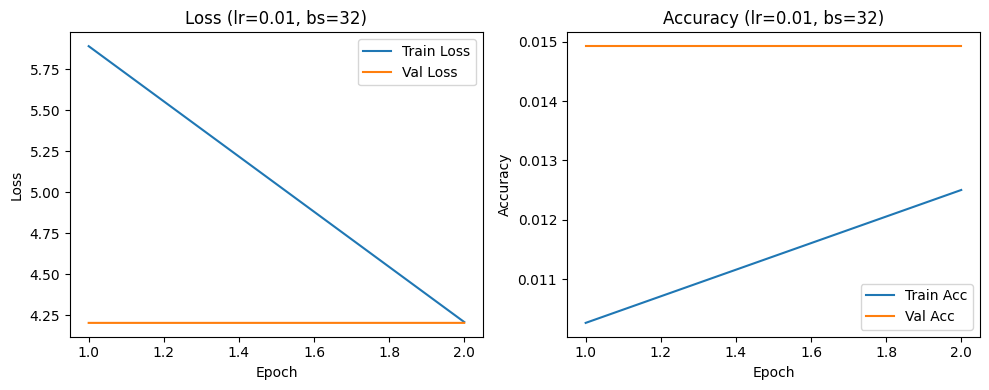

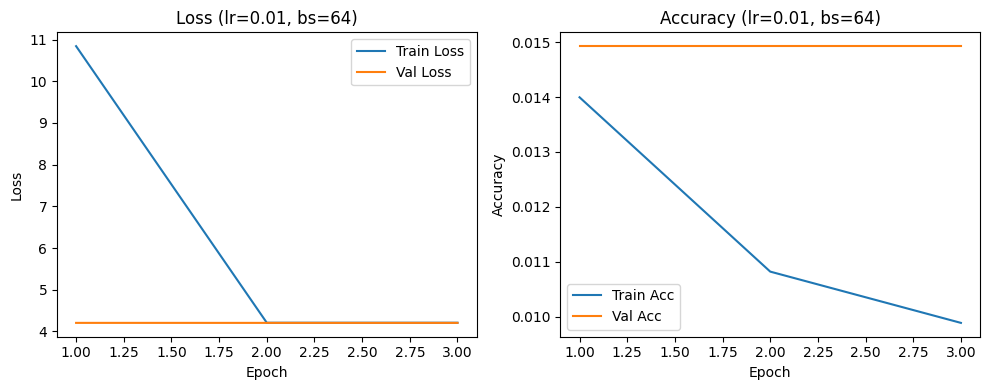

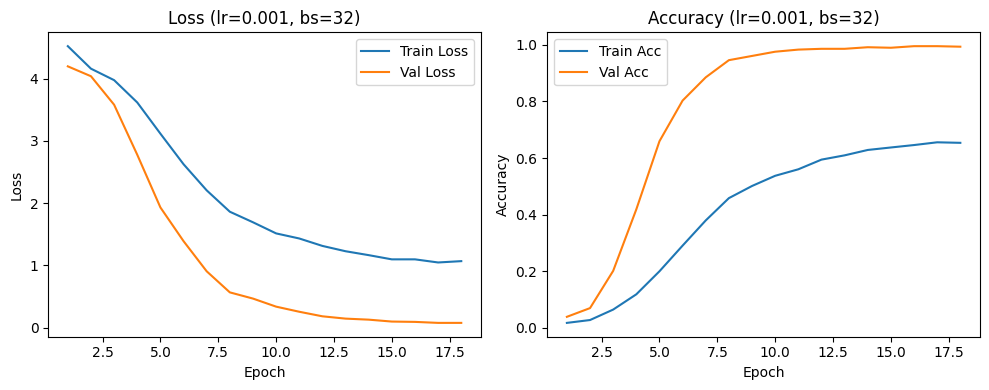

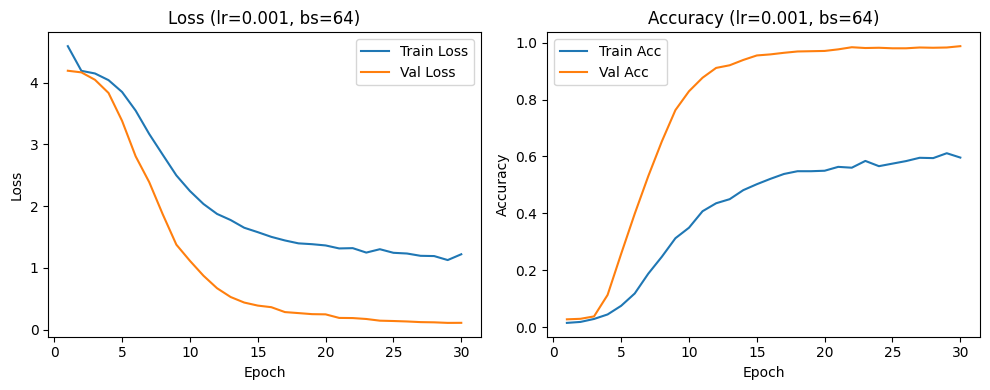

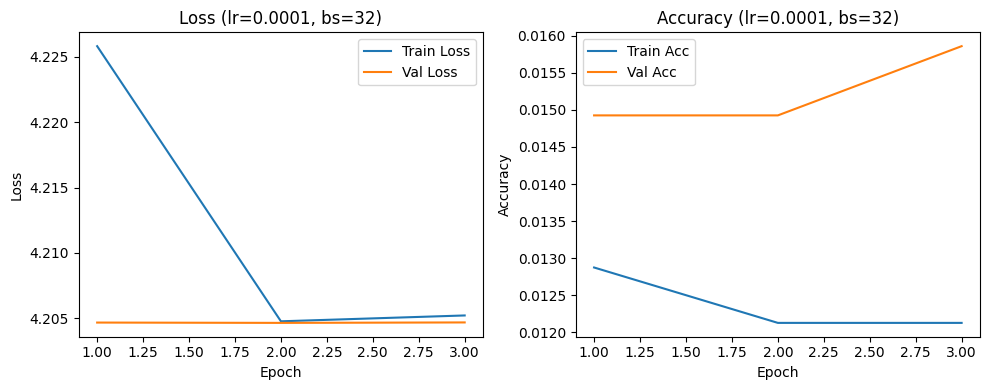

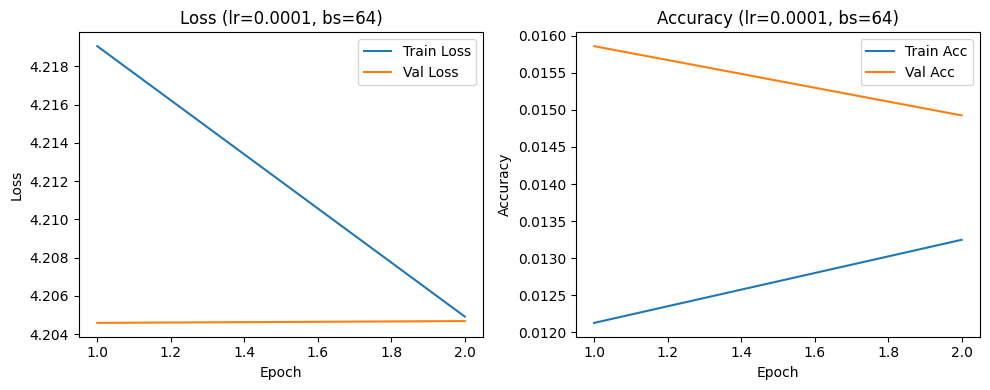

In [ ]:
for (lr, bs), h in histories.items():
    epochs = range(1, len(h['loss']) + 1)
    plt.figure(figsize=(10, 4))

    # Loss eğrisi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, h['loss'],    label='Train Loss')
    plt.plot(epochs, h['val_loss'],label='Val Loss')
    plt.title(f'Loss (lr={lr}, bs={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy eğrisi
    plt.subplot(1, 2, 2)
    plt.plot(epochs, h['accuracy'],    label='Train Acc')
    plt.plot(epochs, h['val_accuracy'],label='Val Acc')
    plt.title(f'Accuracy (lr={lr}, bs={bs})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Her model denemesinin en iyi doğruluk ve en düşük kayıp değerlerini içeren hiper-parametre sonuç tablosu oluşturuldu.  

A hyperparameter results table is created showing the best accuracy and lowest loss for each model trial.


In [ ]:
import pandas as pd

records = []
for (lr, bs), h in histories.items():
    records.append({
        'learning_rate': lr,
        'batch_size':    bs,
        'max_val_acc':   max(h['val_accuracy']),
        'min_val_loss':  min(h['val_loss'])
    })
df_results = pd.DataFrame(records).sort_values(
    by='max_val_acc', ascending=False
).reset_index(drop=True)

df_results


,learning_rate,batch_size,max_val_acc,min_val_loss
0,0.0010,32,0.995336,0.074799
1,0.0010,64,0.987873,0.110327
2,0.0001,32,0.015858,4.204634
3,0.0001,64,0.015858,4.204595
4,0.0100,32,0.014925,4.204967
5,0.0100,64,0.014925,4.204752


In [16]:
best      = df_results.iloc[0]
lr_best   = best.learning_rate
bs_best   = int(best.batch_size)

En iyi hiper-parametreler ile final model yeniden oluşturuldu, eğitim ve test değerlendirmesi gerçekleştirildi.
  
The final model is rebuilt with the best hyperparameters, and both training and test evaluations are performed.


In [ ]:
import numpy as np
# Best combinationn
best      = df_results.iloc[0]
lr_best   = best.learning_rate
bs_best   = int(best.batch_size)

# Train + val data set prep
full_train = orig_train.shuffle(1000) \
                       .batch(bs_best) \
                       .prefetch(tf.data.AUTOTUNE)
val_ds_bs  = orig_val.batch(bs_best) \
                     .prefetch(tf.data.AUTOTUNE)

model_final = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])
model_final.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_best),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
model_final.fit(
    full_train,
    validation_data=val_ds_bs,
    epochs=50,
    callbacks=[es],
    verbose=2
)

orig_test   = test_ds.unbatch()
test_ds_bs  = orig_test.batch(bs_best) \
                       .prefetch(tf.data.AUTOTUNE)

for x_batch, y_batch in test_ds_bs.take(1):
    q_loss, q_acc = model_final.evaluate(x_batch, y_batch, verbose=2)
    print(f"[Quick test] Loss: {q_loss:.4f}, Acc: {q_acc:.4f}")
    break

x_list, y_list = [], []
for x_batch, y_batch in test_ds_bs:
    x_list.append(x_batch.numpy())
    y_list.append(y_batch.numpy())

x_test = np.concatenate(x_list, axis=0)
y_test = np.concatenate(y_list, axis=0)

test_loss, test_acc = model_final.evaluate(x_test, y_test, verbose=2)
print(f"[Full test] Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")


Epoch 1/50


C:\Users\Can\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Can\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


168/168 - 39s - 232ms/step - accuracy: 0.0164 - loss: 4.3620 - val_accuracy: 0.0243 - val_loss: 4.1875
Epoch 2/50
168/168 - 38s - 228ms/step - accuracy: 0.0233 - loss: 4.1813 - val_accuracy: 0.0364 - val_loss: 4.1289
Epoch 3/50
168/168 - 38s - 228ms/step - accuracy: 0.0291 - loss: 4.1279 - val_accuracy: 0.0644 - val_loss: 4.0542
Epoch 4/50
168/168 - 38s - 226ms/step - accuracy: 0.0485 - loss: 4.0188 - val_accuracy: 0.1082 - val_loss: 3.7360
Epoch 5/50
168/168 - 38s - 228ms/step - accuracy: 0.0720 - loss: 3.8107 - val_accuracy: 0.2369 - val_loss: 3.3199
Epoch 6/50
168/168 - 38s - 228ms/step - accuracy: 0.1155 - loss: 3.5317 - val_accuracy: 0.3396 - val_loss: 2.8298
Epoch 7/50
168/168 - 38s - 228ms/step - accuracy: 0.1635 - loss: 3.2035 - val_accuracy: 0.5317 - val_loss: 2.2870
Epoch 8/50
168/168 - 38s - 228ms/step - accuracy: 0.2010 - loss: 2.9361 - val_accuracy: 0.6213 - val_loss: 1.8609
Epoch 9/50
168/168 - 38s - 226ms/step - accuracy: 0.2476 - loss: 2.6889 - val_accuracy: 0.7080 - va

Test verisi yeniden batch'lenerek model üzerinde hem hızlı kontrol hem de tüm test seti ile detaylı değerlendirme yapıldı.  

The test data is re-batched, allowing both a quick check and a full evaluation on the entire test set.


In [ ]:
orig_test   = test_ds.unbatch()
test_ds_bs  = orig_test.batch(bs_best) \
                       .prefetch(tf.data.AUTOTUNE)

for x_batch, y_batch in test_ds_bs.take(1):
    q_loss, q_acc = model_final.evaluate(x_batch, y_batch, verbose=2)
    print(f"[Quick test] Loss: {q_loss:.4f}, Acc: {q_acc:.4f}")
    break

x_list, y_list = [], []
for x_batch, y_batch in test_ds_bs:
    x_list.append(x_batch.numpy())
    y_list.append(y_batch.numpy())

x_test = np.concatenate(x_list, axis=0)
y_test = np.concatenate(y_list, axis=0)

test_loss, test_acc = model_final.evaluate(x_test, y_test, verbose=2)
print(f"[Full test] Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

1/1 - 0s - 95ms/step - accuracy: 0.0938 - loss: 4.8116
[Quick test] Loss: 4.8116, Acc: 0.0938
42/42 - 2s - 57ms/step - accuracy: 0.0828 - loss: 4.7315
[Full test] Loss: 4.7315, Acc: 0.0828


Test verisi için karışıklık matrisi ve sınıflandırma raporu oluşturularak modelin detaylı performansı incelendi.  

A confusion matrix and classification report are generated for the test set to analyze the model's detailed performance.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━

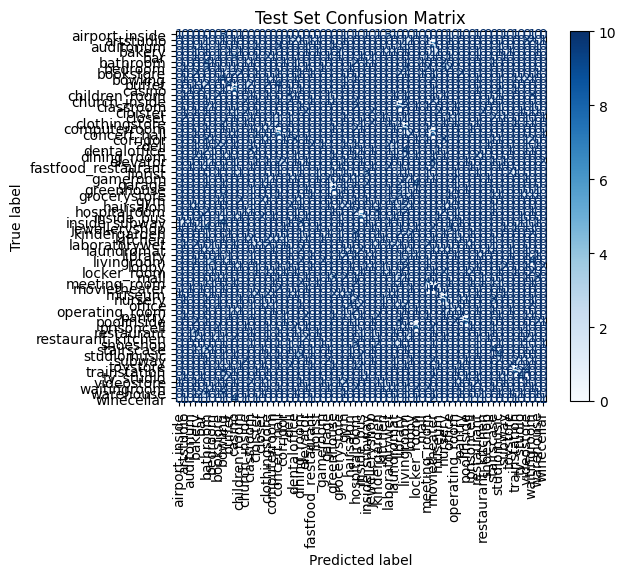

                     precision    recall  f1-score   support

     airport_inside       0.20      0.05      0.08        20
          artstudio       0.00      0.00      0.00        20
         auditorium       0.00      0.00      0.00        18
             bakery       0.04      0.05      0.05        19
                bar       0.00      0.00      0.00        18
           bathroom       0.08      0.22      0.11        18
            bedroom       0.00      0.00      0.00        21
          bookstore       0.00      0.00      0.00        20
            bowling       0.08      0.20      0.11        20
             buffet       0.22      0.20      0.21        20
             casino       0.17      0.32      0.22        19
      children_room       0.00      0.00      0.00        18
      church_inside       0.14      0.11      0.12        19
          classroom       0.00      0.00      0.00        18
           cloister       0.07      0.05      0.06        20
             closet    

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_true = np.concatenate([y.numpy() for x, y in test_ds_bs], axis=0)
y_pred = np.concatenate([
    np.argmax(model_final.predict(x), axis=1) for x, y in test_ds_bs
], axis=0)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Test Set Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


Test veri kümesinin yapısı, etiket dağılımı ve örnek görüntüler kontrol edildi.  

The structure, label distribution, and sample images of the test dataset are inspected.


x_batch shape: (32, 224, 224, 3)
y_batch shape: (32,)
Unique labels in this batch: [ 4  9 14 17 18 21 27 29 30 32 33 35 36 37 39 40 42 44 45 49 50 52 55 63
 65]

Class distribution in test set:
  airport_inside : 20
  artstudio      : 20
  auditorium     : 18
  bakery         : 19
  bar            : 18
  bathroom       : 18
  bedroom        : 21
  bookstore      : 20
  bowling        : 20
  buffet         : 20
  casino         : 19
  children_room  : 18
  church_inside  : 19
  classroom      : 18
  cloister       : 20
  closet         : 18
  clothingstore  : 18
  computerroom   : 18
  concert_hall   : 20
  corridor       : 21
  deli           : 19
  dentaloffice   : 21
  dining_room    : 18
  elevator       : 21
  fastfood_restaurant: 17
  florist        : 19
  gameroom       : 20
  garage         : 18
  greenhouse     : 20
  grocerystore   : 21
  gym            : 18
  hairsalon      : 21
  hospitalroom   : 20
  inside_bus     : 23
  inside_subway  : 21
  jewelleryshop  : 22
  kinderga

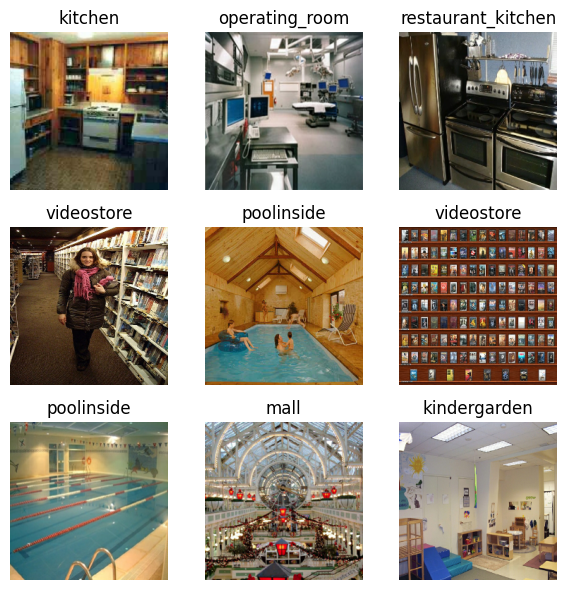

In [ ]:
for x_batch, y_batch in test_ds.take(1):
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("Unique labels in this batch:", np.unique(y_batch.numpy()))
    break

labels = [int(y.numpy()) for x, y in test_ds.unbatch()]
labels = np.array(labels)
unique, counts = np.unique(labels, return_counts=True)
print("\nClass distribution in test set:")
for cls, cnt in zip(unique, counts):
    print(f"  {class_names[cls]:<15}: {cnt}")

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for ax, (img, lbl) in zip(axes.flatten(), test_ds.unbatch().take(9)):
    ax.imshow(img.numpy())
    ax.set_title(class_names[int(lbl.numpy())])
    ax.axis('off')

plt.tight_layout()
plt.show()


# PART 2

Veri çeşitliliğini artırmak için yeniden veri artırma (data augmentation) katmanı tanımlandı. 
 
A data augmentation layer is redefined to increase dataset diversity.


In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name='data_augmentation')


Eğitim verisi shuffle edilip batch'lendikten sonra augmentation uygulandı, ardından validation seti hazırlandı.
  
The training data is shuffled, batched, then augmented; the validation set is prepared without augmentation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

orig_train = train_ds.unbatch()

train_ds_tl = (
    orig_train
    .shuffle(1000)
    .batch(bs_best)  
    .map(lambda x, y: (data_augmentation(x), y),
         num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

orig_val = val_ds.unbatch()
val_ds_tl = (
    orig_val
    .batch(bs_best)
    .prefetch(AUTOTUNE)
)


VGG16 önceden eğitilmiş modelinin gövdesi dondurularak, yalnızca yeni eklenen katmanlar (head) eğitildi.
  
The VGG16 pretrained model's body is frozen, and only the newly added head layers are trained.


In [ ]:
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import VGG16, vgg16

base_model = VGG16(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), dtype=tf.float32)
x = vgg16.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_tl = models.Model(inputs, outputs, name='VGG16_head')

# Compile & summary
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_tl.summary()

# Head-only eğitimi
es_head = callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
history_head = model_tl.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=10,
    callbacks=[es_head],
    verbose=2
)


Model: "VGG16_head"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 512)       │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │    131,328 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 67)        │     17,219 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,863,235 (56.70 MB)

 Trainable params: 148,547 (580.26 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


C:\Users\Can\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


168/168 - 732s - 4s/step - accuracy: 0.0927 - loss: 4.3246 - val_accuracy: 0.3032 - val_loss: 2.8420
Epoch 2/10
168/168 - 629s - 4s/step - accuracy: 0.2237 - loss: 3.1177 - val_accuracy: 0.4711 - val_loss: 1.9486
Epoch 3/10
168/168 - 629s - 4s/step - accuracy: 0.3411 - loss: 2.5439 - val_accuracy: 0.5485 - val_loss: 1.6511
Epoch 4/10
168/168 - 620s - 4s/step - accuracy: 0.3999 - loss: 2.2526 - val_accuracy: 0.6157 - val_loss: 1.3828
Epoch 5/10
168/168 - 618s - 4s/step - accuracy: 0.4314 - loss: 2.0985 - val_accuracy: 0.6642 - val_loss: 1.2001
Epoch 6/10
168/168 - 618s - 4s/step - accuracy: 0.4676 - loss: 1.9602 - val_accuracy: 0.6726 - val_loss: 1.1009
Epoch 7/10
168/168 - 621s - 4s/step - accuracy: 0.4891 - loss: 1.8256 - val_accuracy: 0.6884 - val_loss: 1.0748
Epoch 8/10
168/168 - 617s - 4s/step - accuracy: 0.5132 - loss: 1.7241 - val_accuracy: 0.6959 - val_loss: 1.0362
Epoch 9/10
168/168 - 618s - 4s/step - accuracy: 0.5329 - loss: 1.6638 - val_accuracy: 0.7090 - val_loss: 0.9615
Epo

VGG16 modelinin yalnızca son bloğu (block5) eğitilebilir yapılarak düşük öğrenme oranıyla ince ayar (fine-tuning) gerçekleştirildi.  

Only the last block (block5) of the VGG16 model is set to be trainable, and fine-tuning is performed with a low learning rate.


In [ ]:
from tensorflow.keras import callbacks

# Base modelin tümünü aç sonra baştan birkaç bloğu freeze et
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = layer.name.startswith("block5_")

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune 
es_ft = callbacks.EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True
)
history_finetune = model_tl.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=10,
    callbacks=[es_ft],
    verbose=2
)


Epoch 1/10
168/168 - 725s - 4s/step - accuracy: 0.4130 - loss: 2.2329 - val_accuracy: 0.6744 - val_loss: 1.0976
Epoch 2/10
168/168 - 711s - 4s/step - accuracy: 0.5350 - loss: 1.6432 - val_accuracy: 0.7201 - val_loss: 0.9582
Epoch 3/10
168/168 - 721s - 4s/step - accuracy: 0.5645 - loss: 1.5127 - val_accuracy: 0.7519 - val_loss: 0.8562
Epoch 4/10
168/168 - 692s - 4s/step - accuracy: 0.5930 - loss: 1.4119 - val_accuracy: 0.7659 - val_loss: 0.8019
Epoch 5/10
168/168 - 28007s - 167s/step - accuracy: 0.5997 - loss: 1.3588 - val_accuracy: 0.7780 - val_loss: 0.7441
Epoch 6/10
168/168 - 762s - 5s/step - accuracy: 0.6246 - loss: 1.3002 - val_accuracy: 0.7920 - val_loss: 0.7066
Epoch 7/10
168/168 - 717s - 4s/step - accuracy: 0.6300 - loss: 1.2505 - val_accuracy: 0.8032 - val_loss: 0.6748
Epoch 8/10
168/168 - 710s - 4s/step - accuracy: 0.6462 - loss: 1.1777 - val_accuracy: 0.8116 - val_loss: 0.6161
Epoch 9/10
168/168 - 707s - 4s/step - accuracy: 0.6662 - loss: 1.1305 - val_accuracy: 0.8134 - val_l

Test seti üzerinde model değerlendirmesi yapılır, karışıklık matrisi (confusion matrix) ve sınıflandırma raporu hesaplanır.  

The model is evaluated on the test set, and the confusion matrix along with the classification report is generated.


1/1 - 3s - 3s/step - accuracy: 0.5312 - loss: 1.6342
[Quick TL eval] Loss: 1.6342, Acc: 0.5312
42/42 - 116s - 3s/step - accuracy: 0.6187 - loss: 1.4531
[Full TL eval] Loss: 1.4531, Acc: 0.6187
42/42 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step


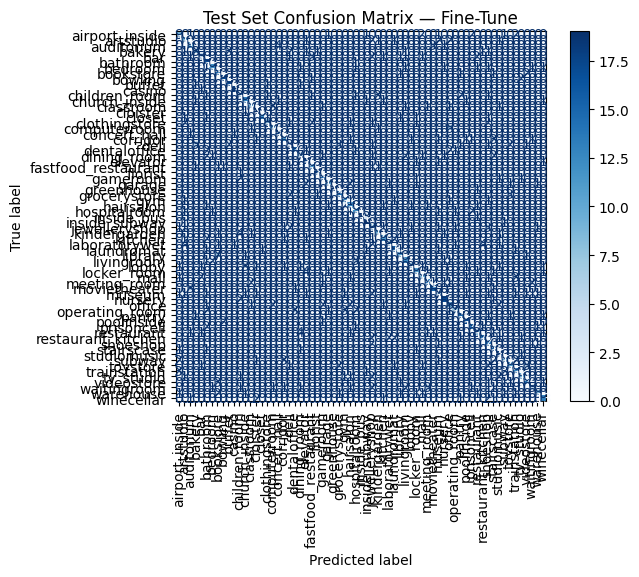

                     precision    recall  f1-score   support

     airport_inside       0.45      0.45      0.45        20
          artstudio       0.40      0.50      0.44        20
         auditorium       0.56      0.56      0.56        18
             bakery       0.47      0.42      0.44        19
                bar       0.45      0.28      0.34        18
           bathroom       0.47      0.94      0.63        18
            bedroom       0.71      0.57      0.63        21
          bookstore       0.50      0.75      0.60        20
            bowling       0.85      0.85      0.85        20
             buffet       0.77      0.85      0.81        20
             casino       0.90      0.95      0.92        19
      children_room       0.42      0.44      0.43        18
      church_inside       0.65      0.68      0.67        19
          classroom       0.67      0.56      0.61        18
           cloister       0.76      0.95      0.84        20
             closet    

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Test setini unbatch batch ile hazırla
orig_test  = test_ds.unbatch()
test_ds_tl = orig_test.batch(bs_best).prefetch(tf.data.AUTOTUNE)

xb, yb = next(iter(test_ds_tl))
q_loss, q_acc = model_tl.evaluate(xb, yb, verbose=2)
print(f"[Quick TL eval] Loss: {q_loss:.4f}, Acc: {q_acc:.4f}")

x_list, y_list = [], []
for xb, yb in test_ds_tl:
    x_list.append(xb.numpy())
    y_list.append(yb.numpy())
x_test = np.concatenate(x_list, axis=0)
y_test = np.concatenate(y_list, axis=0)

test_loss, test_acc = model_tl.evaluate(x_test, y_test, verbose=2)
print(f"[Full TL eval] Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

# Confusion Matrix
y_pred = np.argmax(model_tl.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Test Set Confusion Matrix — Fine-Tune")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=class_names))


Farklı model yaklaşımlarının doğruluk ve kayıp değerleri karşılaştırılarak tablo halinde gösterilir ve CSV dosyasına kaydedilir.  

Validation accuracy and loss metrics of different model approaches are compared, displayed in a table, and saved as a CSV file.


In [ ]:
from IPython.display import display, FileLink

records = []
for (lr, bs), h in histories.items():
    records.append({
        'learning_rate': lr,
        'batch_size':    bs,
        'max_val_acc':   max(h['val_accuracy']),
        'min_val_loss':  min(h['val_loss'])
    })
df_results = pd.DataFrame(records).sort_values(
    by='max_val_acc', ascending=False
).reset_index(drop=True)

part1_val_acc  = df_results.loc[0, 'max_val_acc']
part1_val_loss = df_results.loc[0, 'min_val_loss']
head_val_acc   = max(history_head.history['val_accuracy'])
head_val_loss  = min(history_head.history['val_loss'])
ft_val_acc     = max(history_finetune.history['val_accuracy'])
ft_val_loss    = min(history_finetune.history['val_loss'])

df_cmp = pd.DataFrame([
    {'Method': 'Part 1 CNN',       'Val Accuracy': part1_val_acc, 'Val Loss': part1_val_loss},
    {'Method': 'VGG16 Head-only',  'Val Accuracy': head_val_acc,  'Val Loss': head_val_loss},
    {'Method': 'VGG16 Fine-tune',  'Val Accuracy': ft_val_acc,    'Val Loss': ft_val_loss},
])

display(df_cmp)
df_cmp.to_csv('validation_comparison.csv', index=False)
display(FileLink('validation_comparison.csv'))


,Method,Val Accuracy,Val Loss
0,Part 1 CNN,0.995336,0.074799
1,VGG16 Head-only,0.721082,0.938893
2,VGG16 Fine-tune,0.827425,0.568702


c:\Users\Can\Desktop\validation_comparison.csv

Modellerin doğruluk ve kayıp değerlerinin karşılaştırılması için bar grafikler çizilir.  

Bar charts are plotted to compare the validation accuracy and loss metrics of different models.


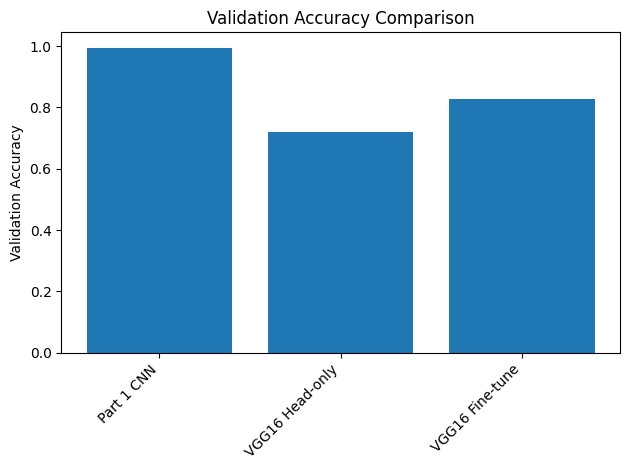

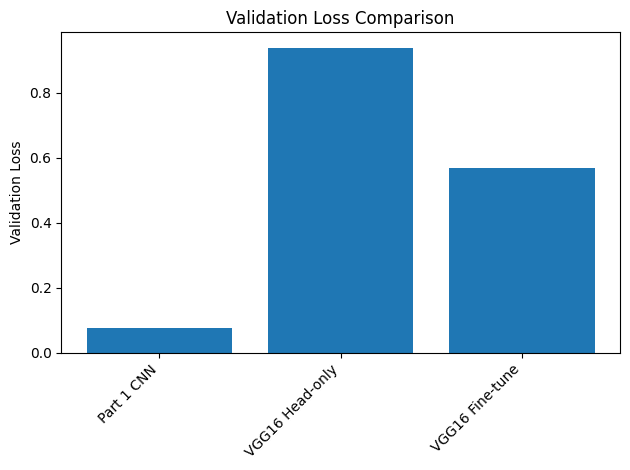

In [ ]:
plt.figure()
plt.bar(df_cmp['Method'], df_cmp['Val Accuracy'])
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45, ha='right')
plt.title('Validation Accuracy Comparison')
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(df_cmp['Method'], df_cmp['Val Loss'])
plt.ylabel('Validation Loss')
plt.xticks(rotation=45, ha='right')
plt.title('Validation Loss Comparison')
plt.tight_layout()
plt.show()


Baş ve Fine-Tune modelleri için epoch bazlı doğruluk ve kayıp eğrileri çizilir.  

Validation accuracy and loss curves are plotted per epoch for both head-only and fine-tuned models.


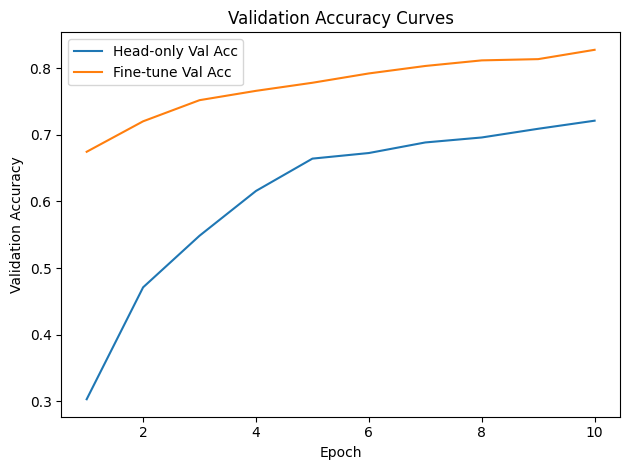

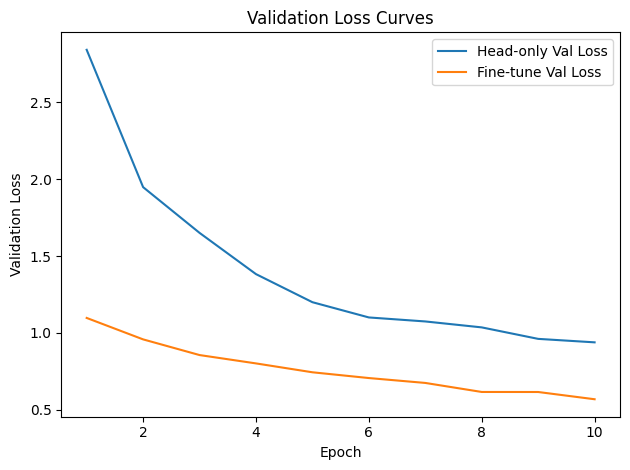

In [ ]:
epochs_head = range(1, len(history_head.history['val_accuracy']) + 1)
epochs_ft   = range(1, len(history_finetune.history['val_accuracy']) + 1)

plt.figure()
plt.plot(epochs_head, history_head.history['val_accuracy'], label='Head-only Val Acc')
plt.plot(epochs_ft,   history_finetune.history['val_accuracy'], label='Fine-tune Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Validation Accuracy')
plt.legend(); plt.title('Validation Accuracy Curves')
plt.tight_layout(); plt.show()

plt.figure()
plt.plot(epochs_head, history_head.history['val_loss'], label='Head-only Val Loss')
plt.plot(epochs_ft,   history_finetune.history['val_loss'], label='Fine-tune Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Validation Loss')
plt.legend(); plt.title('Validation Loss Curves')
plt.tight_layout(); plt.show()


## Genel Sonuç ve Değerlendirme

Proje kapsamında öncelikle temel bir CNN mimarisi oluşturularak hiperparametre optimizasyonu yapılmıştır. Ardından VGG16 transfer öğrenme modeli hem yalnızca "head" kısmı eğitilerek hem de tüm model "fine-tune" edilerek değerlendirilmiştir. Modeller, hem validasyon verisi üzerinde hem de bağımsız test seti üzerinde detaylı olarak karşılaştırılmıştır.

**Validation (Doğrulama) Sonuçları:**

| Model              | Val Accuracy | Val Loss |
|--------------------|--------------|----------|
| Temel CNN          | 0.9953       | 0.0748   |
| VGG16 Head-Only    | 0.7210       | 0.9389   |
| VGG16 Fine-Tune    | 0.8274       | 0.5687   |

Bu tabloda görüldüğü üzere, Temel CNN modeli validasyon setinde oldukça yüksek doğruluk sağlamıştır. Ancak bu durum aşırı öğrenmenin (overfitting) bir göstergesi olabilir.

**Test Seti Sonuçları:**

| Model              | Test Accuracy | Macro F1-Score |
|--------------------|---------------|----------------|
| Temel CNN          | 0.08          | 0.08           |
| VGG16 Fine-Tune    | 0.62          | 0.61           |

Buradan açıkça görülmektedir ki, Temel CNN modeli test setinde düşük başarı sağlamıştır. Buna karşılık VGG16 Fine-Tune modeli çok daha dengeli ve yüksek başarı sunmuştur.

**Sonuç Yorumu:**

Validasyon setinde yüksek doğruluk veren Temel CNN modeli, test setinde başarısız olmuştur. Bu durum, modelin veriye aşırı uyum sağladığını, yani overfitting yaptığını göstermektedir.

Öte yandan, VGG16 transfer öğrenme modeli test setinde %62 doğruluk ve %61 F1-skoru ile çok daha iyi performans sergilemiştir. Bu sebeple, gerçek dünya senaryolarında kullanılacak model olarak VGG16 Fine-Tune mimarisi tercih edilmesi mantıklıdır.

---

## General Results and Evaluation

Within the scope of this project, a basic CNN architecture was first implemented with hyperparameter optimization. Subsequently, the VGG16 transfer learning model was evaluated both with head-only training and full fine-tuning. All models were compared in detail on both validation and independent test datasets.

**Validation Results:**

| Model              | Val Accuracy | Val Loss |
|--------------------|--------------|----------|
| Basic CNN          | 0.9953       | 0.0748   |
| VGG16 Head-Only    | 0.7210       | 0.9389   |
| VGG16 Fine-Tune    | 0.8274       | 0.5687   |

As seen above, the Basic CNN model achieved very high validation accuracy, which may indicate overfitting.

**Test Set Results:**

| Model              | Test Accuracy | Macro F1-Score |
|--------------------|---------------|----------------|
| Basic CNN          | 0.08          | 0.08           |
| VGG16 Fine-Tune    | 0.62          | 0.61           |

It is clearly observed that the Basic CNN model failed significantly on the test set. In contrast, the VGG16 Fine-Tune model provided much more balanced and higher performance.

**Conclusion:**

Although the Basic CNN model yielded high validation accuracy, it performed poorly on the test set, indicating overfitting. On the other hand, the VGG16 transfer learning model achieved much better real-world results with 62% test accuracy and a 61% macro F1-score.

Therefore, for real-world usage, the VGG16 Fine-Tune architecture is the recommended and more reliable model.
